<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Sergey-Kim-folder/Sergey%20Kim/iris_classification_v4%D0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Идентификация пациента по радужке. Опыт 4б. 89 пациентов
Круглые изображения

## Загрузка библиотек

In [ ]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Для работы с архивами
import zipfile

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

# Гиперпараметры

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/iris'       # Папка для обучающего набора данных
TEST_PATH           = '/content/iris_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.2                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 192                   # Ширина изображения для нейросети
IMG_HEIGHT          = 144                   # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 5                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.05                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.05                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.05                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 330                   # Число эпох обучения
BATCH_SIZE          = 8                     # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

# Подготовка данных

In [ ]:
# Загрузка zip-архива со своего гугл диска на диск виртуальной машины colab (89 классов)
gdown.download('https://drive.google.com/uc?id=1JvaIpxRvM7ja4NLFxCbEotPV5iCxoIgf', None, quiet=True)

'iris89.zip'

In [ ]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "iris89.zip" -d {TRAIN_PATH}

In [ ]:
# Путь к архиву iris89.zip
zip_path = '/content/iris89.zip'

# Путь к директории, в которую нужно распаковать архивы
extract_path = TRAIN_PATH

# Создаем директорию, если ее нет
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Открываем архив Iris_ID.zip
with zipfile.ZipFile(zip_path, 'r') as main_zip:
    # Итерируемся по всем архивам внутри Iris_ID.zip
    for archive_name in main_zip.namelist():
        # Если архив - iris1_*zip, то распаковываем его
        # print(archive_name)
        if 'iris' in archive_name:
            with main_zip.open(archive_name) as archive_file:
                with zipfile.ZipFile(archive_file, 'r') as archive:
                    # Извлекаем все файлы из архива в директорию extract_path
                    archive.extractall(path=extract_path)
                    
                    # Создаем папки для каждого класса и перемещаем файлы в соответствующую папку
                    for i in range(1, 65):
                        class_folder = os.path.join(extract_path, f'{i:03}')
                        if not os.path.exists(class_folder):
                            os.makedirs(class_folder)
                        for file_name in ['%03dL_%d.png' % (i, j) for j in range(1, 4)] + ['%03dR_%d.png' % (i, j) for j in range(1, 4)]:
                            file_path = os.path.join(extract_path, file_name)
                            if os.path.exists(file_path):
                                os.replace(file_path, os.path.join(class_folder, file_name))


In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 89, метки классов: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089']


In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_files.sort()                                     # Сортировка имен файлов по алфавиту
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} фото, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса 001: 6 фото, для теста выделено файлов: 1
Размер класса 002: 6 фото, для теста выделено файлов: 1
Размер класса 003: 6 фото, для теста выделено файлов: 1
Размер класса 004: 6 фото, для теста выделено файлов: 1
Размер класса 005: 6 фото, для теста выделено файлов: 1
Размер класса 006: 6 фото, для теста выделено файлов: 1
Размер класса 007: 6 фото, для теста выделено файлов: 1
Размер класса 008: 6 фото, для теста выделено файлов: 1
Размер класса 009: 6 фото, для теста выделено файлов: 1
Размер класса 010: 6 фото, для теста выделено файлов: 1
Размер класса 011: 6 фото, для теста выделено файлов: 1
Размер класса 012: 6 фото, для теста выделено файлов: 1
Размер класса 013: 6 фото, для теста выделено файлов: 1
Размер класса 014: 6 фото, для теста выделено файлов: 1
Размер класса 015: 6 фото, для теста выделено файлов: 1
Размер класса 016: 6 фото, для теста выделено файлов: 1
Размер класса 017: 6 фото, для теста выделено файлов: 1
Размер класса 018: 6 фото, для теста выделено фа

# Аугментация и формирование выборок

In [ ]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 531 images belonging to 89 classes.
Found 114 images belonging to 89 classes.
Found 139 images belonging to 89 classes.


In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (8, 144, 192, 3), (8, 89), батчей: 67
Формы данных   проверочной выборки: (8, 144, 192, 3), (8, 89), батчей: 15
Формы данных      тестовой выборки: (139, 144, 192, 3), (139, 89), батчей: 1

Метки классов тренировочной выборки: {'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29, '031': 30, '032': 31, '033': 32, '034': 33, '035': 34, '036': 35, '037': 36, '038': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '051': 50, '052': 51, '053': 52, '054': 53, '055': 54, '056': 55, '057': 56, '058': 57, '059': 58, '060': 59, '061': 60, '062': 61, '063': 62, '064': 63, '065': 64, '066': 65, '067': 66, '068': 67

# Проверка работы генераторов выборок

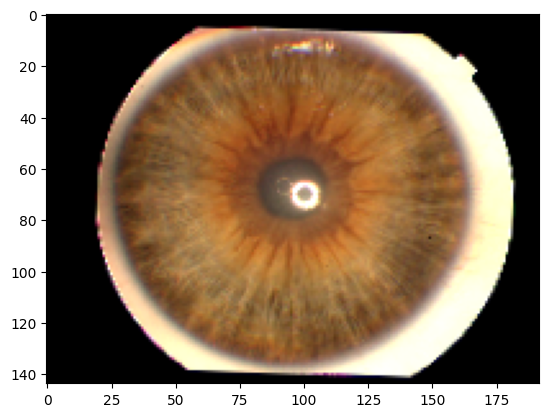

In [ ]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [ ]:
# Картинка в виде трехмерного массива нормализованных пикселей (от 0 до 1):
train_generator[1][0][2]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(8),   # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=4             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])  
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

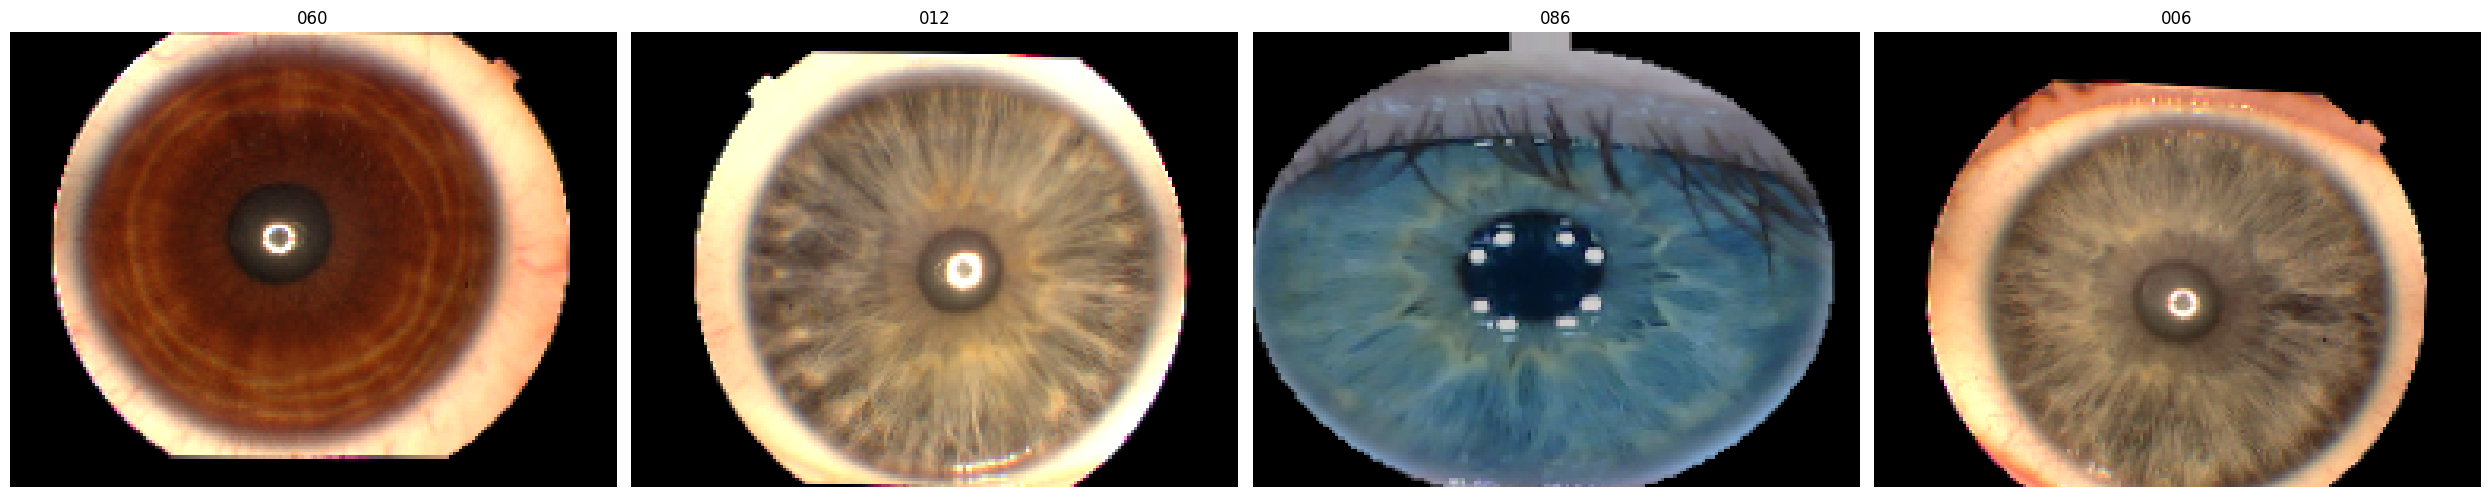

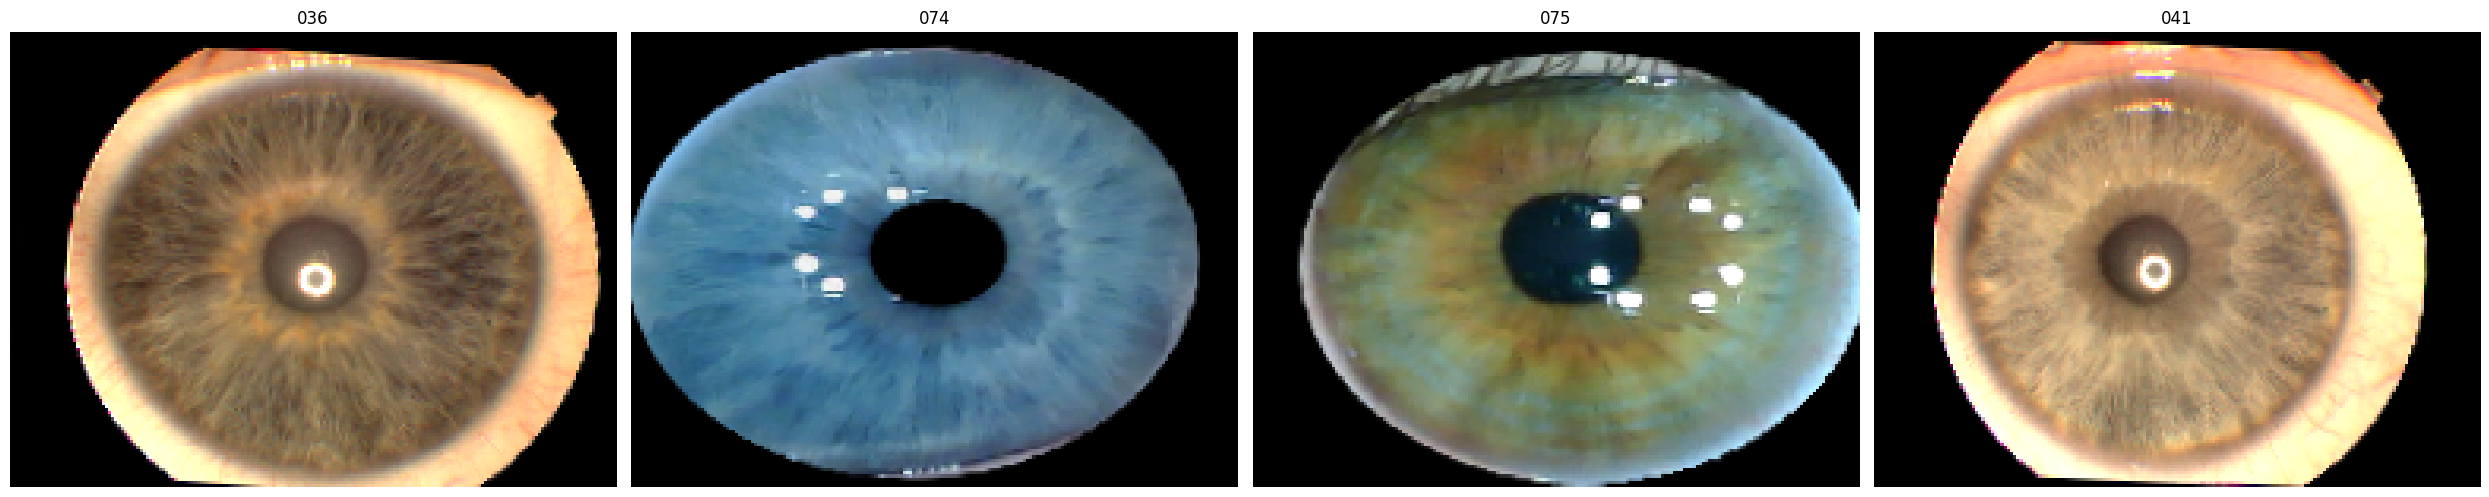

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

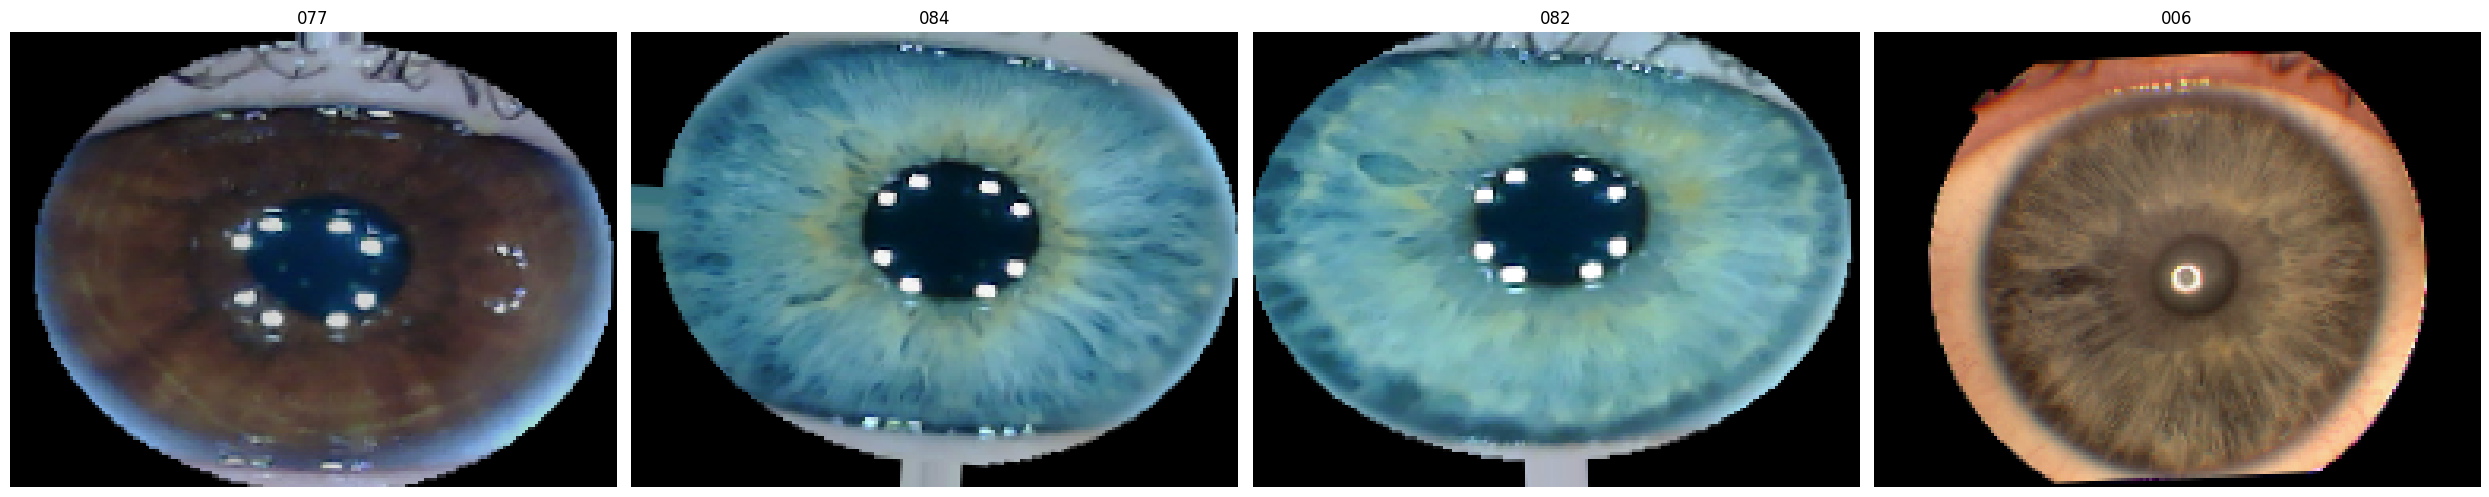

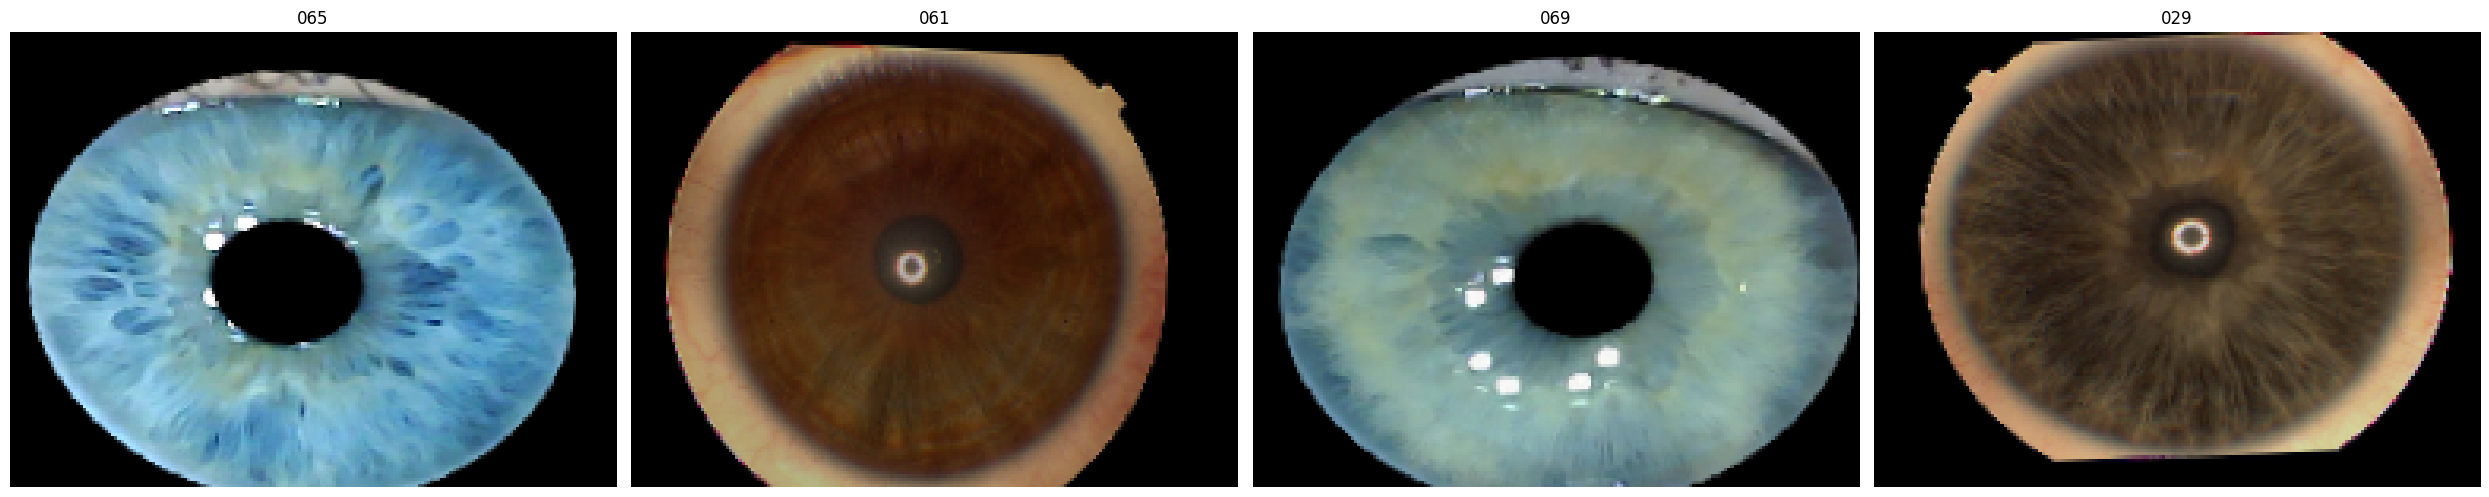

In [ ]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

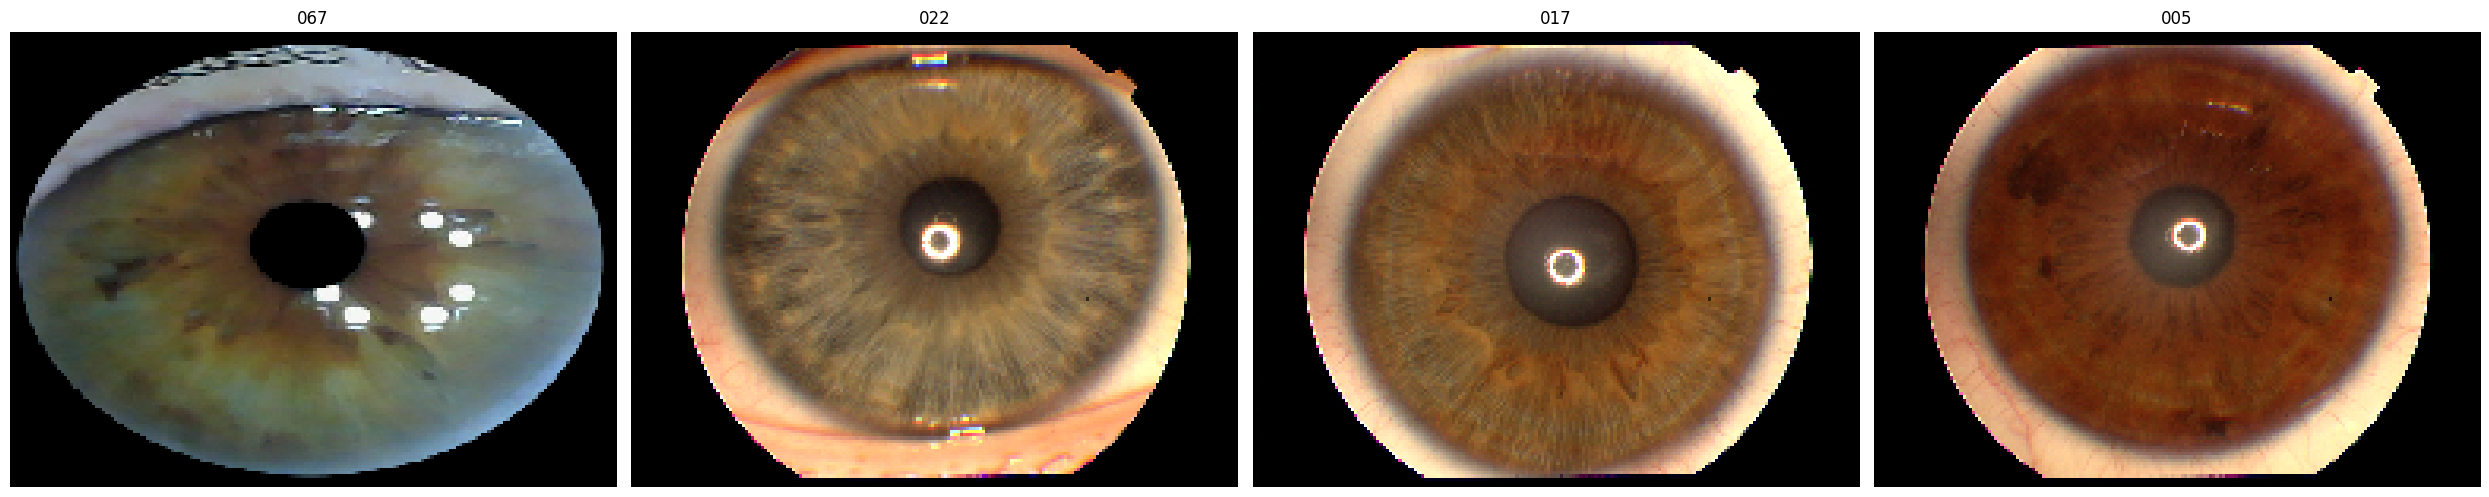

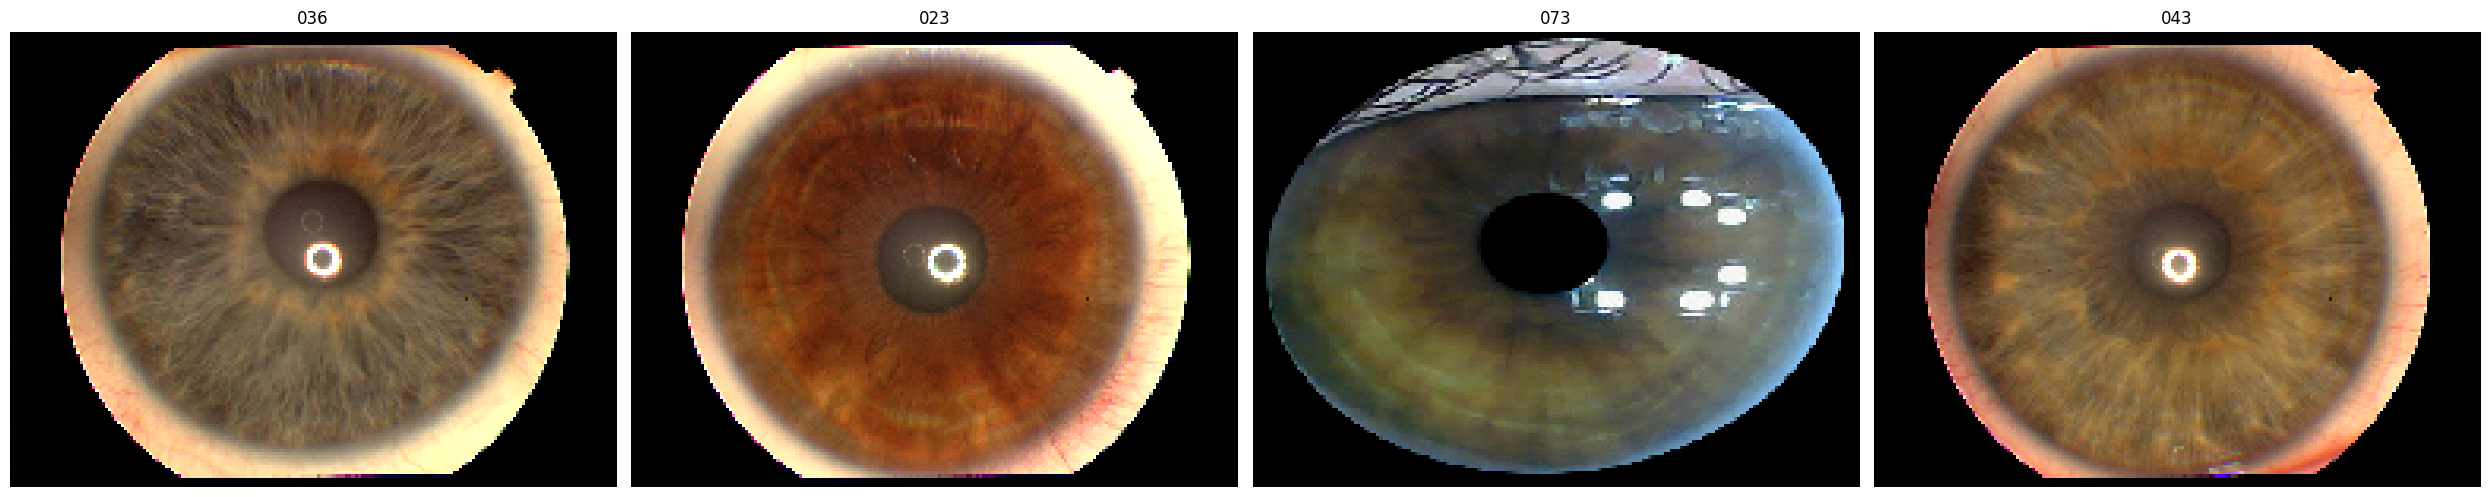

In [ ]:
# Вывод примеров из 0-го (единственного) батча test_generator
show_batch(test_generator[0])

# Создание и обучение модели нейронной сети

## Сервисные функции

In [ ]:
from tensorflow.keras.callbacks import Callback

class SaveModelOnAccuracy(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1, min_accuracy=0.0):
        super(SaveModelOnAccuracy, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.min_accuracy = min_accuracy
        self.best_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        if current_accuracy >= self.min_accuracy and current_accuracy > self.best_accuracy:
            self.model.save(self.filepath)
            self.best_accuracy = current_accuracy
            if self.verbose == 1:
                print(f" Модель сохранена с точностью {self.best_accuracy * 100:.2f} %")

In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5),        # размер полотна для графиков
                        min_accuracy=0.8,       # минимальное значение accuracy для сохранения модели
                        checkpoint_path='/content/Best_model/best_model.h5'):

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    # model.summary()

    # Создание обратного вызова для сохранения модели с заданным значением accuracy
    checkpoint = SaveModelOnAccuracy(filepath=checkpoint_path,
                                     monitor='val_loss',
                                     mode='min',
                                     save_best_only=True,
                                     verbose=1,
                                     min_accuracy=min_accuracy)

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data,
                        callbacks=[checkpoint])  # Передача обратного вызова в качестве списка)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

    return history

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model, 
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1], 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

In [ ]:
# Функция создания архива, который будет разбит на части по archive_size байт в каждом
def split_file_to_archives(file_path, archive_size):
    # Создание папки для хранения архивов
    os.makedirs('archives', exist_ok=True)

    # Открытие файла в режиме чтения бинарного файла
    with open(file_path, 'rb') as file:
        data = file.read()  # Чтение содержимого файла

    # Определение количества архивов
    num_archives = (len(data) + archive_size - 1) // archive_size

    # Разбиение данных на архивы и сохранение их на диск
    for i in range(num_archives):
        start = i * archive_size
        end = (i + 1) * archive_size
        archive_data = data[start:end]  # Выделение части данных для текущего архива
        archive_name = f'archives/{model_name}_{i}.zip'  # Генерация имени архива
        with zipfile.ZipFile(archive_name, 'w', zipfile.ZIP_DEFLATED) as archive:
            archive.writestr('data', archive_data)  # Запись данных в архив

    print(f'{num_archives} архивов создано.')

"""
# Пример использования
# Создание архива, который будет разбит на части по archive_size байт в каждом
file_path = '/content/' + model_name  # Путь к файлу, который нужно разбить на архивы
archive_size = 500 * 1024 * 1024      # Размер одного архива в байтах

split_file_to_archives(file_path, archive_size)
"""

"\n# Пример использования\n# Создание архива, который будет разбит на части по archive_size байт в каждом\nfile_path = '/content/' + model_name  # Путь к файлу, который нужно разбить на архивы\narchive_size = 500 * 1024 * 1024      # Размер одного архива в байтах\n\nsplit_file_to_archives(file_path, archive_size)\n"

In [ ]:
# Сохранение лучшей модели на мой Google Disk
def save_model_to_drive(model, save_path):

    from google.colab import drive
    import shutil

    # Подключение к Google Диску
    drive.mount('/content/gdrive')

    # Сохранение модели в указанную папку на Google Диск
    shutil.copyfile(model, '/content/gdrive/MyDrive/' + save_path)

In [ ]:
from tensorflow.keras.models import load_model

# Загрузка лучшей модели
def load_best_model(model_path):
    # Загрузка модели из указанного файла
    best_model = load_model(model_path)
    
    return best_model

# Архитектура модели нейронной сети

In [ ]:
model = Sequential()

# Сверточные слои
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Полносвязные слои
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 192, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 96, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 72, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 96, 64)        36928     
                                                        

## Обучение модели

In [ ]:
from google.colab import drive

# Подключение к Google Диску для сохранения лучшей модели
drive.mount('/content/gdrive')

# Путь к папке на Google Диске
gdrive_path = '/content/gdrive/My Drive'

# Путь для сохранения модели на Google Диск
checkpoint_path = f'{gdrive_path}/Best_model/best_model.h5'

Mounted at /content/gdrive


Epoch 1/330
67/67 [==============================] - 25s 174ms/step - loss: 4.4387 - accuracy: 0.0226 - val_loss: 4.3373 - val_accuracy: 0.0351
Epoch 2/330
67/67 [==============================] - 10s 151ms/step - loss: 4.2220 - accuracy: 0.0169 - val_loss: 4.1515 - val_accuracy: 0.0263
Epoch 3/330
67/67 [==============================] - 11s 158ms/step - loss: 4.0891 - accuracy: 0.0414 - val_loss: 4.1008 - val_accuracy: 0.0614
Epoch 4/330
67/67 [==============================] - 11s 159ms/step - loss: 3.9805 - accuracy: 0.0490 - val_loss: 3.9793 - val_accuracy: 0.0789
Epoch 5/330
67/67 [==============================] - 10s 145ms/step - loss: 3.9040 - accuracy: 0.0697 - val_loss: 3.7694 - val_accuracy: 0.0789
Epoch 6/330
67/67 [==============================] - 10s 150ms/step - loss: 3.7547 - accuracy: 0.0923 - val_loss: 3.7930 - val_accuracy: 0.0965
Epoch 7/330
67/67 [==============================] - 11s 158ms/step - loss: 3.5982 - accuracy: 0.1205 - val_loss: 3.4836 - val_accuracy:

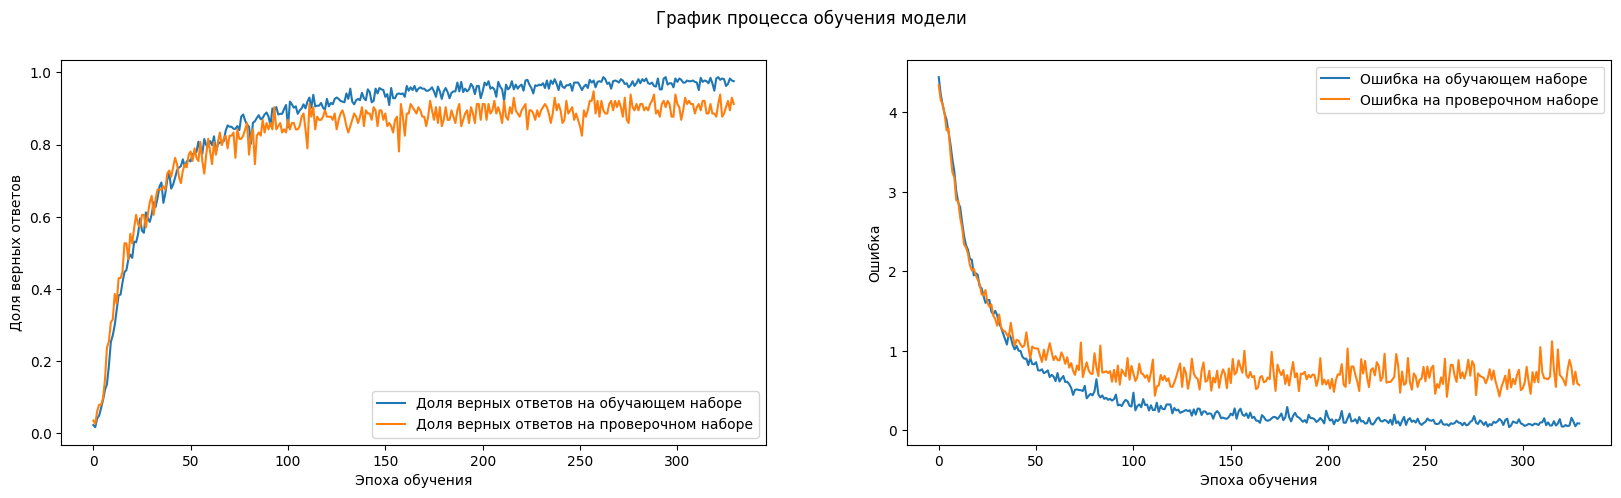

In [ ]:
# Компиляция и обучение модели на заданных параметрах
# В качестве проверочных используются тестовые данные
compile_train_model(model, 
                    train_generator,
                    validation_generator,
                    checkpoint_path=checkpoint_path)

In [ ]:
# Загрузка лучшей модели
model = load_best_model('/content/gdrive/MyDrive/Best_model/best_model.h5')

5/5 [==============================] - 2s 170ms/step


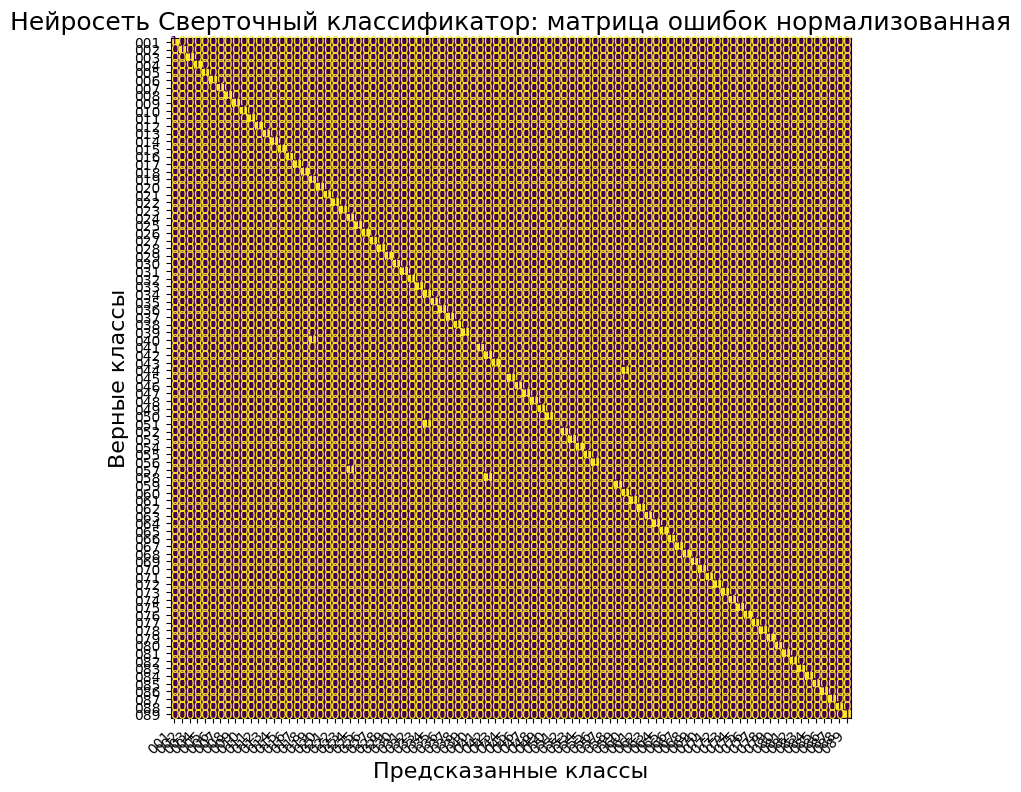

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: 001                  100% сеть отнесла к классу 001                  - ВЕРНО :-)
Класс: 002                  100% сеть отнесла к классу 002                  - ВЕРНО :-)
Класс: 003                  100% сеть отнесла к классу 003                  - ВЕРНО :-)
Класс: 004                  100% сеть отнесла к классу 004                  - ВЕРНО :-)
Класс: 005                  100% сеть отнесла к классу 005                  - ВЕРНО :-)
Класс: 006                  100% сеть отнесла к классу 006                  - ВЕРНО :-)
Класс: 007                  100% сеть отнесла к классу 007                  - ВЕРНО :-)
Класс: 008                  100% сеть отнесла к классу 008                  - ВЕРНО :-)
Класс: 009                  100% сеть отнесла к классу 009                  - ВЕРНО :-)
Класс: 010                  100% сеть отнесла к классу 010             

In [ ]:
# Вывод результатов оценки работы модели на тестовых данных
eval_model(model, test_generator[0][0], test_generator[0][1],
            class_labels=CLASS_LIST, 
            title='Сверточный классификатор')

# Подведение итогов

1. 89 изображений. Линейный размер изображения 192 * 144. 
2. Точность распознавания 94%. 
3. Время обучения 1 час.